In [5]:
import random
import copy
from collections import deque, namedtuple
import wandb
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import pygame
from pygame.locals import QUIT

## Environment

In [2]:
env = gym.make('LunarLanderContinuous-v2')
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space)

State shape:  (8,)
Number of actions:  Box(-1.0, 1.0, (2,), float32)


In [3]:
# Set the seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

## Critic

In [4]:
class Critic(nn.Module):
    '''
    Critic Network used in the DDPG (Deep Deterministic Policy Gradient) algorithm.

    Parameters:
        state_size (int): Size of the state space.
        action_size (int): Size of the action space.
        layer_size (int): Number of units in the hidden layers.

    Attributes:
        input_layer (torch.nn.Linear): Input layer of the neural network.
        hidden_layer1 (torch.nn.Linear): First hidden layer of the neural network.
        hidden_layer2 (torch.nn.Linear): Second hidden layer of the neural network.
        output_layer (torch.nn.Linear): Output layer of the neural network.

    Methods:
        forward(state, action=None):
            Performs forward propagation through the Critic Network.

    '''

    def __init__(self, state_size, action_size, layer_size):

        """
        Initializes the Critic Network.

        Parameters:
            state_size (int): Size of the state space.
            action_size (int): Size of the action space.
            layer_size (int): Number of units in the hidden layers.
        """

        super(Critic, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.device = torch.device('cpu')

        # Input layer
        self.input_layer = nn.Linear(in_features=self.state_size, out_features=layer_size)
        # Hidden layer

        self.hidden_layer1 = nn.Linear(in_features=layer_size, out_features=layer_size)

        ### tested also with two hidden layers
        #self.hidden_layer2 = nn.Linear(in_features=layer_size, out_features=layer_size)

        # Output layer
        self.output_layer = nn.Linear(in_features=layer_size, out_features=self.action_size)


    def forward(self, state, action = None):
        """
        Performs forward propagation through the Critic Network based on current state and action.

        Parameters:
            state (torch.Tensor): Current state.
            action (torch.Tensor): Executed action.

        Returns:
            torch.Tensor: Q-values representing the expected return for the given state-action pairs.
        """

        # Combine state and action into an input tensor x
        x = torch.cat([state, action], 1)

        # Pass input tensor x through the input layer, applying the ReLU activation function to introduce non-linearity.
        x = torch.relu(self.input_layer(x))

        # Pass the output from the input layer (x) through the first (and second) hidden layer, applying the ReLU activation function.
        x = torch.relu(self.hidden_layer1(x))
        #x = torch.relu(self.hidden_layer2(x))

         # Pass the output from the first hidden layer (x) through the output layer, and return the result. This represents the Q-values for the given state-action pairs.
        return self.output_layer(x)

## Actor

In [5]:
class Actor(nn.Module):
    '''
    DDPG Actor Network used in the DDPG (Deep Deterministic Policy Gradient) algorithm.

    Parameters:
        state_size (int): Size of the state space.
        action_size (int): Size of the action space.
        layer_size (int): Number of units in the hidden layers.

    Attributes:
        input_layer (torch.nn.Linear): Input layer of the neural network.
        hidden_layer1 (torch.nn.Linear): First hidden layer of the neural network.
        hidden_layer2 (torch.nn.Linear): Second hidden layer of the neural network.
        output_layer (torch.nn.Linear): Output layer of the neural network.

    Methods:
        forward(state):
            Performs forward propagation through the Actor Network.

    '''

    def __init__(self, state_size, action_size, layer_size):
        """
        Initializes the Actor Network.

        Parameters:
            state_size (int): Size of the state space.
            action_size (int): Size of the action space.
            layer_size (int): Number of units in the hidden layers.
        """

        super(Actor, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.device = torch.device('cpu')

        # Input layer of the neural network
        self.input_layer = nn.Linear(in_features=self.state_size, out_features=layer_size)

        # First (and second) hidden layer of the neural network
        self.hidden_layer1 = nn.Linear(in_features=layer_size, out_features=layer_size)
        
        ### tested also with two hidden layers
        #self.hidden_layer2 = nn.Linear(in_features=layer_size, out_features=layer_size)

        # Output layer of the neural network
        self.output_layer = nn.Linear(in_features=layer_size, out_features=self.action_size)

    def forward(self, state):
        """
        Performs forward propagation through the Actor Network.

        Parameters:
            state (torch.Tensor): Current state.

        Returns:
            torch.Tensor: Action tensor representing the actor's output.
        """

        # Pass the input state through the input layer, applying the ReLU activation function to introduce non-linearity.
        x = torch.relu(self.input_layer(state))

        # Pass the output from the input layer (x) through the first (and second) hidden layer, applying the ReLU activation function.
        x = torch.relu(self.hidden_layer1(x))
        #x = torch.relu(self.hidden_layer2(x))

        # Pass the output from the first hidden layer (x) through the output layer and apply the tanh activation function to obtain the actor's action output.
        return torch.tanh(self.output_layer(x))

## Replay-Buffer

In [6]:
# From: https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py#L154C1-L189C32
class ReplayBuffer:
    """
    Replay Buffer to store experience tuples with the structure: (state, action, reward, next_state, done).

    Parameters:
        buffer_size (int): Maximum size of the replay buffer.
        batch_size (int): Size of the randomly sampled batch of experiences.

    Attributes:
        memory (collections.deque): Data structure to store experiences.
        batch_size (int): Size of the randomly sampled batch of experiences.
        experience (namedtuple): Namedtuple representing an experience tuple with fields "state", "action", "reward", "next_state", "done".

    Methods:
        add(state, action, reward, next_state, done):
            Adds a new experience tuple to the replay buffer.
        sample():
            Randomly samples a batch of experiences from the replay buffer.
        __len__():
            Returns the current size of the replay buffer.
    """

    def __init__(self, buffer_size, batch_size):
        """
        Initializes the Replay Buffer.

        Parameters:
            buffer_size (int): Maximum size of the replay buffer.
            batch_size (int): Size of the randomly sampled batch of experiences.
        """

        self.device = torch.device('cpu')

        # Data structure to store experiences
        self.memory = deque(maxlen=buffer_size)

        # Namedtuple representing an experience tuple
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        """
        Adds a new experience tuple to the replay buffer.

        Parameters:
            state (numpy.ndarray): Current state.
            action (numpy.ndarray): Action taken in the current state.
            reward (float): Reward received after taking the action.
            next_state (numpy.ndarray): Next state after taking the action.
            done (bool): True if the episode is finished, otherwise False.
        """

        # Create namedtuple object from the experience
        exp = self.experience(state, action, reward, next_state, done)

        # Add the experience object to memory
        self.memory.append(exp)

    def sample(self):
        """
        Randomly samples a batch of experiences from the replay buffer.

        Returns:
            tuple: Tuple containing tensors representing the states, actions, rewards, next_states, and dones.
        """

        # Randomly sample a batch of experiences
        experiences = random.sample(self.memory, k=self.batch_size)

         # Convert states to a tensor and move to the specified device
        states = torch.from_numpy( np.stack([e.state if not isinstance(e.state, tuple) else e.state[0] for e in experiences])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """
        Returns the current size of the replay buffer.
        """
        return len(self.memory)

## Noise

In [7]:
# Based on: https://github.com/rail-berkeley/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py

class OUNoise(object):
    """
    Ornstein-Uhlenbeck Noise (OUNoise) for action exploration in continuous action spaces.

    Parameters:
        action_space: Action space of the environment.
        mu (float): Mean or starting point for the noise process.
        theta (float): Parameter controlling the speed of mean reversion for the noise process.
        max_sigma (float): Maximum value for the noise standard deviation.
        min_sigma (float): Minimum value for the noise standard deviation.
        decay_period (int): Number of timesteps over which the noise standard deviation decays.

    Attributes:
        mu (float): Mean or starting point for the noise process.
        theta (float): Parameter controlling the speed of mean reversion for the noise process.
        sigma (float): Current value of the noise standard deviation.
        max_sigma (float): Maximum value for the noise standard deviation.
        min_sigma (float): Minimum value for the noise standard deviation.
        decay_period (int): Number of timesteps over which the noise standard deviation decays.
        action_dim (int): Dimension of the action space.
        low (numpy.ndarray): Lower bounds of the action space.
        high (numpy.ndarray): Upper bounds of the action space.

    Methods:
        reset():
            Reset the noise state to the mean (mu).
        evolve_state():
            Evolve the state of the noise process using Ornstein-Uhlenbeck process.
        get_action(action, t=0):
            Get the noisy action by adding noise to the given action.
    """
    
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.2, min_sigma=0.2, decay_period=50):
        """
        Initializes the OUNoise object.

        Parameters:
            Already described in doc-string of OUNoise-class
        """

        self.mu = mu
        self.theta = theta
        self.sigma = max_sigma
        self.max_sigma = max_sigma
        self.min_sigma = min_sigma
        self.decay_period = decay_period
        self.action_dim = action_space.shape[0]
        self.low = action_space.low
        self.high = action_space.high
        self.reset()

    def reset(self):
        """
        Reset the noise state to the mean (mu).
        """
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        """
        Evolve the state of the noise process using Ornstein-Uhlenbeck process.

        Returns:
            numpy.ndarray: Evolved state of the noise process.
        """
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t):
        """
        Get the noisy action by adding noise to the given action.

        Parameters:
            action (numpy.ndarray): Original action without noise.
            t (int): Current timestep.

        Returns:
            numpy.ndarray: Noisy action obtained by adding noise.
        """
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

In [8]:
# Based on: https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py#L132C1-L152C26
# --> Other implementation of OUNoise without decay term 

class OUNoise_without_decay:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [9]:
class GaussianNoise:
    '''
    Gaussian Noise for action exploration in continuous action spaces as alternative for Ornstein-Uhlenbeck Noise.

    Parameters:
        dim (int): Dimension of the noise vector.
        mu (numpy.ndarray or None): Mean of the Gaussian distribution. If None, defaults to a zero vector of the given dimension.
        std (numpy.ndarray or None): Standard deviation of the Gaussian distribution. If None, defaults to a vector of ones multiplied by 0.1 of the given dimension.

    Attributes:
        mu (numpy.ndarray): Mean of the Gaussian distribution.
        std (numpy.ndarray): Standard deviation of the Gaussian distribution.

    Methods:
        sample():
            Sample from the Gaussian distribution to get a noise vector.
    '''
    def __init__(self, dim, mu=None, std=None):
        """
        Initializes the GaussianNoise object.

        Parameters:
            dim (int): Dimension of the noise vector.
            mu (numpy.ndarray or None): Mean of the Gaussian distribution.
            std (numpy.ndarray or None): Standard deviation of the Gaussian distribution.
        """
        self.mu = mu if mu else np.zeros(dim)
        self.std = std if std else np.ones(dim) * .1

    def sample(self):
        """
        Sample from the Gaussian distribution to get a noise vector.

        Returns:
            numpy.ndarray: Noise vector sampled from the Gaussian distribution.
        """
        return np.random.normal(self.mu, self.std)

## Agent

In [10]:
# Based on: https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py

class DDPGAgent:
    '''
    Deep Deterministic Policy Gradient (DDPG) agent for continuous action spaces. 

    Parameters:
        env (gym.Env): Gym environment to interact with.
        layer_size (int): Number of units in the hidden layers of the neural networks.
        actor_lr (float): Learning rate for the actor's optimizer.
        critic_lr (float): Learning rate for the critic's optimizer.
        gamma (float): Discount factor for future rewards.
        tau (float): Soft update parameter for the target networks.
        memory_size (int): Maximum size of the replay buffer.
        batch_size (int): Size of the randomly sampled batch of experiences.

    Attributes:
        action_size (int): Dimension of the action space.
        state_size (int): Dimension of the state space.
        gamma (float): Discount factor for future rewards.
        tau (float): Soft update parameter for the target networks.
        batch_size (int): Size of the randomly sampled batch of experiences.
        actor (Actor): Actor network to learn the policy.
        actor_target (Actor): Target Actor network for soft updates.
        critic (Critic): Critic network to learn the action-value function.
        critic_target (Critic): Target Critic network for soft updates.
        actor_optimizer (torch.optim.Adam): Optimizer for the actor network.
        critic_optimizer (torch.optim.Adam): Optimizer for the critic network.
        memory (ReplayBuffer): Replay buffer to store experience tuples.

    Methods:
        step(state, action, reward, next_state, done):
            Performs one step of learning and adds the experience to the replay buffer.
        act(state):
            Returns an action using the current policy (actor).
        learn(experiences):
            Updates the actor and critic networks using a batch of experiences.
        soft_update():
            Updates the target networks using a soft update scheme.
    '''

    def __init__(self, env, layer_size, actor_lr, critic_lr, gamma, tau, memory_size, batch_size):
        """
        Initializes the DDPGAgent.

        Parameters:
            Already described in doc-string of DDPGAgent-class 
        """
        
        self.action_size = env.action_space.shape[0]
        self.state_size = env.observation_space.shape[0]
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size

        # Initialize Actor, Critic, Actor Target and Critic Target networks
        self.actor = Actor(state_size=self.state_size, action_size=self.action_size, layer_size=layer_size)
        self.actor_target = Actor(state_size=self.state_size, action_size=self.action_size, layer_size=layer_size)
        self.critic = Critic(state_size=self.state_size + self.action_size, action_size=self.action_size, layer_size=layer_size)
        self.critic_target = Critic(state_size=self.state_size + self.action_size, action_size=self.action_size, layer_size=layer_size)

        # Copy weights of actor and critic nn into target nns
        for actor_weights, actor_target_weights, critic_weights, critic_target_weights in zip(self.actor.parameters(),
                                                                      self.actor_target.parameters(),
                                                                      self.critic.parameters(),
                                                                      self.critic_target.parameters()):
            actor_target_weights.data.copy_(actor_weights.data)
            critic_target_weights.data.copy_(critic_weights.data)

        # Initialize Optimizers
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

        # Initialize Replay Buffer
        self.memory = ReplayBuffer(memory_size, self.batch_size)

    def step(self, state, action, reward, next_state, done):
        """
        Performs one step of learning and adds the experience to the replay buffer.

        Parameters:
            state (numpy.ndarray): Current state.
            action (numpy.ndarray): Action taken in the current state.
            reward (float): Reward received after taking the action.
            next_state (numpy.ndarray): Next state after taking the action.
            done (bool): True if the episode is finished, otherwise False.
        """

        # Save experience in Replay Buffer
        self.memory.add(state, action, reward, next_state, done)

        # Perform learning if enough samples are available in memory
        if len(self.memory) > self.batch_size:
            # Pick random batch of experiences
            experiences = self.memory.sample()
            # Learn from experiences
            self.learn(experiences)

    def act(self, state):
        """
        Returns an action using the current policy (actor).

        Parameters:
            state (numpy.ndarray): Current state.

        Returns:
            numpy.ndarray: Action chosen by the actor.
        """

        state = torch.from_numpy(state)
        return self.actor(state).cpu().detach().numpy()
    
    def learn(self, experiences):
        """
        Updates the actor and critic networks using a batch of experiences sampled from the replay buffer.
        It calculates the critic loss and actor loss based on the current policy and target networks, then 
        updates the actor and critic networks using their respective optimizers. Finally, it updates the target networks 
        using the soft update mechanism. This process allows the agent to improve its policy and action-value function through 
        experience gained from interacting with the environment.

        Parameters:
            experiences (tuple): Tuple containing tensors representing the states, actions, rewards, next_states, and dones.
        """

        states, actions, rewards, next_states, dones = experiences

        # Compute Q-values for the given (state, action) pairs using the critic network
        q_values = self.critic(states, actions)
        # Get the next actions predicted by the target actor network for the next_states
        next_actions = self.actor_target(next_states)
        # Compute Q-values for the next_states and next_actions using the target critic network
        q_next = self.critic_target(next_states, next_actions)
        # Compute the target Q-values (q_targets) by adding the discounted future rewards to the current rewards
        q_targets = rewards + (self.gamma * q_next * (1 - dones))
        # Calculate the critic loss using Mean Squared Error (MSE) loss between q_values and q_targets
        critic_loss = F.mse_loss(q_values, q_targets)

        # Compute the actor loss using the critic network to encourage the actor to choose actions that maximize Q-values
        actor_loss = -self.critic(states, self.actor(states)).mean()


        # ----------------- Minimize the loss of Actor ---------------- #
        # Zero out the gradients of the actor optimizer
        self.actor_optimizer.zero_grad()
        # Backpropagate the actor loss to compute the gradients
        actor_loss.backward()
        # Update the actor network's weights using the gradients
        self.actor_optimizer.step()

        # ----------------- Minimize the loss of Critic ---------------- #
         # Zero out the gradients of the critic optimizer
        self.critic_optimizer.zero_grad()
        # Backpropagate the critic loss to compute the gradients
        critic_loss.backward()
        # Update the critic network's weights using the gradients
        self.critic_optimizer.step()
        # Update the target networks (actor_target and critic_target) using the soft_update method
        self.soft_update()


    def soft_update(self):
        """
        Updates the target networks using a soft update scheme.
        """

        # Copy weights of actor and critic nn into target nns
        for actor_weights, actor_target_weights, critic_weights, critic_target_weights in zip(self.actor.parameters(),
                                                                      self.actor_target.parameters(),
                                                                      self.critic.parameters(),
                                                                      self.critic_target.parameters()):
            actor_target_weights.data.copy_(self.tau * actor_weights.data + (1. - self.tau) * actor_target_weights.data)
            critic_target_weights.data.copy_(self.tau * critic_weights.data + (1. - self.tau) * critic_target_weights.data)

## Hyperparameteroptimierung mit Grid-Search

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ner_diseases. Use `wandb login --relogin` to force relogin


Episode: 1, Reward: -270.82, Average Reward: -270.8185411652531 

Model in Episode 1 archived new best reward: -270.82.
Episode: 2, Reward: -291.21, Average Reward: -281.0163939932946 

Episode: 3, Reward: -268.61, Average Reward: -276.87971910512505 

Model in Episode 3 archived new best reward: -268.61.
Episode: 4, Reward: -207.72, Average Reward: -259.59009923198 

Model in Episode 4 archived new best reward: -207.72.
Episode: 5, Reward: -736.08, Average Reward: -354.88796766424457 

Episode: 6, Reward: -620.73, Average Reward: -399.1952467855527 

Episode: 7, Reward: -163.24, Average Reward: -365.48700141639785 

Model in Episode 7 archived new best reward: -163.24.
Episode: 8, Reward: -115.29, Average Reward: -334.212152069632 

Model in Episode 8 archived new best reward: -115.29.
Episode: 9, Reward: -60.24, Average Reward: -303.77133794152667 

Model in Episode 9 archived new best reward: -60.24.
Episode: 10, Reward: -111.38, Average Reward: -284.5320091320838 

Episode: 11, Rew

accumulated_reward,▅▄▃▃▄▃▆▆▅▁▃▄█▅▆▇▂▅▁▄▃▃▅▇▆▆▆▆▆▅▃▆▆▆▆▆▆▄▇▃
episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
accumulated_reward,-530.16481
episode,500
name,256_0.0001_0.0001_0....


Episode: 1, Reward: -182.45, Average Reward: -182.45161145225012 

Model in Episode 1 archived new best reward: -182.45.
Episode: 2, Reward: -95.62, Average Reward: -139.03541076931705 

Model in Episode 2 archived new best reward: -95.62.
Episode: 3, Reward: -718.97, Average Reward: -332.3461519625084 

Episode: 4, Reward: -827.23, Average Reward: -456.0665136215881 

Episode: 5, Reward: -1075.25, Average Reward: -579.9032959855172 

Episode: 6, Reward: -759.9, Average Reward: -609.9029010569881 

Episode: 7, Reward: -873.23, Average Reward: -647.5213958416701 

Episode: 8, Reward: -1416.25, Average Reward: -743.6126794100435 

Episode: 9, Reward: -771.76, Average Reward: -746.7398908458794 

Episode: 10, Reward: -761.56, Average Reward: -748.2214280666997 

Episode: 11, Reward: -887.76, Average Reward: -818.7526538703344 

Episode: 12, Reward: -621.5, Average Reward: -871.3411871414348 

Episode: 13, Reward: -661.28, Average Reward: -865.572427520123 

Episode: 14, Reward: -320.23, A

accumulated_reward,▂▇▇▄▄▅▅▇▅▇▇▆▆▅▇▆▇▇▇▄▅▅▆█▇▇▇▆▆▇▄▇▁▆▄▅▆▅▅▅
episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
accumulated_reward,-881.18133
episode,500
name,256_0.0001_0.0001_0....


Episode: 1, Reward: -387.03, Average Reward: -387.03237445080833 

Model in Episode 1 archived new best reward: -387.03.
Episode: 2, Reward: -196.35, Average Reward: -291.69191197189355 

Model in Episode 2 archived new best reward: -196.35.
Episode: 3, Reward: -349.71, Average Reward: -311.03022722314205 

Episode: 4, Reward: -418.75, Average Reward: -337.96093596492636 

Episode: 5, Reward: -411.61, Average Reward: -352.69044137170806 

Episode: 6, Reward: -399.07, Average Reward: -360.42012245445557 

Episode: 7, Reward: -1028.54, Average Reward: -455.86565146461123 

Episode: 8, Reward: -121.88, Average Reward: -414.11685555730935 

Model in Episode 8 archived new best reward: -121.88.
Episode: 9, Reward: -144.02, Average Reward: -384.10642906403854 

Episode: 10, Reward: -206.37, Average Reward: -366.3325779569607 

Episode: 11, Reward: -131.01, Average Reward: -340.730080670932 

Episode: 12, Reward: -121.1, Average Reward: -333.2045137745939 

Model in Episode 12 archived new be

accumulated_reward,▆▇█▇█▇▇▇▇▆▆▆▇▆▇▇▇▆▇▁▇▆▇▆▆▇▇▆▆▇█▇▇▇▇▇▇█▇█
episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
accumulated_reward,-22.44412
episode,500
name,256_0.0001_0.0001_0....


Episode: 1, Reward: -155.79, Average Reward: -155.7878089624282 

Model in Episode 1 archived new best reward: -155.79.
Episode: 2, Reward: -504.85, Average Reward: -330.3212227160065 

Episode: 3, Reward: -345.37, Average Reward: -335.3361195207612 

Episode: 4, Reward: -296.88, Average Reward: -325.72215857613855 

Episode: 5, Reward: -687.44, Average Reward: -398.0648904310962 

Episode: 6, Reward: -663.98, Average Reward: -442.38333173222424 

Episode: 7, Reward: -441.55, Average Reward: -442.26464889443236 

Episode: 8, Reward: -171.36, Average Reward: -408.4021286181003 

Episode: 9, Reward: -189.08, Average Reward: -384.033339835884 

Episode: 10, Reward: -167.15, Average Reward: -362.3451044059542 

Episode: 11, Reward: -361.91, Average Reward: -382.9573140128831 

Episode: 12, Reward: -549.88, Average Reward: -387.45988823014005 

Episode: 13, Reward: -463.13, Average Reward: -399.2359018955379 

Episode: 14, Reward: -234.75, Average Reward: -393.0231666677431 

Episode: 15, R

accumulated_reward,▆▁▆▃▇▆▆▅▄█▇▇█▆▆▇▇▇▇▆▄▇▃▅▅▅▄▃▃▃▅▄▅▂▄▅▆▆█▇
episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
accumulated_reward,-114.52443
episode,500
name,256_0.0001_0.0001_0....


Episode: 1, Reward: -377.78, Average Reward: -377.7772516755728 

Model in Episode 1 archived new best reward: -377.78.
Episode: 2, Reward: -351.98, Average Reward: -364.8763649306574 

Model in Episode 2 archived new best reward: -351.98.
Episode: 3, Reward: -777.2, Average Reward: -502.3184598480438 

Episode: 4, Reward: -356.66, Average Reward: -465.90412086642505 

Episode: 5, Reward: -809.17, Average Reward: -534.5564960461127 

Episode: 6, Reward: -241.57, Average Reward: -485.7257946053403 

Model in Episode 6 archived new best reward: -241.57.
Episode: 7, Reward: -772.13, Average Reward: -526.6402245904509 

Episode: 8, Reward: -781.33, Average Reward: -558.4764024559455 

Episode: 9, Reward: -367.03, Average Reward: -537.2051122754228 

Episode: 10, Reward: -289.79, Average Reward: -512.463114409677 

Episode: 11, Reward: -281.09, Average Reward: -502.7946766836918 

Episode: 12, Reward: -317.1, Average Reward: -499.3073493233504 

Episode: 13, Reward: -513.08, Average Reward:

accumulated_reward,▆▆▄▁█▇▆▇▇▆▆▆▇▇▇▇▇▇▇▇██▇█▇▇▇▇▇▇▇▇█▇▇▇▇▆▇█
episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
accumulated_reward,-93.15148
episode,500
name,256_0.0001_0.001_0.9...


Episode: 1, Reward: -163.48, Average Reward: -163.4827191511338 

Model in Episode 1 archived new best reward: -163.48.
Episode: 2, Reward: -390.46, Average Reward: -276.97368868242137 

Episode: 3, Reward: -244.77, Average Reward: -266.2378261503008 

Episode: 4, Reward: -400.49, Average Reward: -299.80008517602334 

Episode: 5, Reward: -619.15, Average Reward: -363.6699864810115 

Episode: 6, Reward: -408.06, Average Reward: -371.0677508293874 

Episode: 7, Reward: -355.25, Average Reward: -368.8083239161976 

Episode: 8, Reward: -51.1, Average Reward: -329.09525436053343 

Model in Episode 8 archived new best reward: -51.1.
Episode: 9, Reward: -455.02, Average Reward: -343.08741109523015 

Episode: 10, Reward: -437.32, Average Reward: -352.51085613175366 

Episode: 11, Reward: -478.94, Average Reward: -384.0567762399189 

Episode: 12, Reward: -315.32, Average Reward: -376.54263106899725 

Episode: 13, Reward: -350.25, Average Reward: -387.09107322266857 

Episode: 14, Reward: -474.2

accumulated_reward,▂▂▅▁▅▅▂▇▆▆▇▆▄▆▅▇▇▄▆▆▇▇▇▇█▇▃█▇▆▆▇▆▇▆▄▇▆▅▆
episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
accumulated_reward,-112.09971
episode,500
name,256_0.0001_0.001_0.9...


Episode: 1, Reward: -318.03, Average Reward: -318.03330631253607 

Model in Episode 1 archived new best reward: -318.03.
Episode: 2, Reward: -278.72, Average Reward: -298.3747826091126 

Model in Episode 2 archived new best reward: -278.72.
Episode: 3, Reward: -137.87, Average Reward: -244.87253305280555 

Model in Episode 3 archived new best reward: -137.87.
Episode: 4, Reward: -464.9, Average Reward: -299.8781959744848 

Episode: 5, Reward: -555.41, Average Reward: -350.9836453810931 

Episode: 6, Reward: -962.57, Average Reward: -452.9148655222327 

Episode: 7, Reward: -1097.1, Average Reward: -544.9414117447651 

Episode: 8, Reward: -448.8, Average Reward: -532.9238758918901 

Episode: 9, Reward: -528.53, Average Reward: -532.4357160802446 

Episode: 10, Reward: -489.79, Average Reward: -528.1706549362196 

Episode: 11, Reward: -20.14, Average Reward: -498.3814476914443 

Model in Episode 11 archived new best reward: -20.14.
Episode: 12, Reward: -218.6, Average Reward: -492.3702375

accumulated_reward,▃▄▆▆▁▆▅▅▆▅▆▆▆▆▇▆▄▃▅▄▅▆▆▇▂▄▄█▆▄▄▆█▃▄▄▅▆▆▆
episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
accumulated_reward,-271.44555
episode,500
name,256_0.0001_0.001_0.9...


Episode: 1, Reward: -113.84, Average Reward: -113.84361216716836 

Model in Episode 1 archived new best reward: -113.84.
Episode: 2, Reward: -404.62, Average Reward: -259.2298775077902 

Episode: 3, Reward: -608.24, Average Reward: -375.5680627338052 

Episode: 4, Reward: -628.16, Average Reward: -438.71500787016805 

Episode: 5, Reward: -112.27, Average Reward: -373.42524762940434 

Model in Episode 5 archived new best reward: -112.27.
Episode: 6, Reward: -208.16, Average Reward: -345.8812408680949 

Episode: 7, Reward: -345.97, Average Reward: -345.8944768892522 

Episode: 8, Reward: -373.92, Average Reward: -349.39794163476654 

Episode: 9, Reward: -654.93, Average Reward: -383.345788735234 

Episode: 10, Reward: -199.27, Average Reward: -364.93790488770014 

Episode: 11, Reward: -400.19, Average Reward: -393.57282505130814 

Episode: 12, Reward: -185.03, Average Reward: -371.614682169254 

Episode: 13, Reward: -116.7, Average Reward: -322.4603500558441 

Episode: 14, Reward: -594.5

accumulated_reward,▄▇▇▇▇██▅▇▄▄▇▅▃█▄▄▄▆▄▆▄▅▆▁▇█▆▆█▇▇▇▇▅▆▆▄▆▆
episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
accumulated_reward,-372.81484
episode,500
name,256_0.0001_0.001_0.9...


Episode: 1, Reward: -104.6, Average Reward: -104.60088471500217 

Model in Episode 1 archived new best reward: -104.6.
Episode: 2, Reward: -297.92, Average Reward: -201.2593455442318 

Episode: 3, Reward: -392.88, Average Reward: -265.13159768526174 

Episode: 4, Reward: -128.09, Average Reward: -230.87147603162927 

Episode: 5, Reward: -201.69, Average Reward: -225.03475073918557 

Episode: 6, Reward: -499.86, Average Reward: -270.83968467228954 

Episode: 7, Reward: -968.08, Average Reward: -370.4458153870845 

Episode: 8, Reward: -683.54, Average Reward: -409.5827223745946 

Episode: 9, Reward: -811.86, Average Reward: -454.2801583131514 

Episode: 10, Reward: -779.42, Average Reward: -486.79456319131003 

Episode: 11, Reward: -592.4, Average Reward: -535.5742230106637 

Episode: 12, Reward: -539.99, Average Reward: -559.7811330647176 

Episode: 13, Reward: -667.81, Average Reward: -587.2742294285634 

Episode: 14, Reward: -773.39, Average Reward: -651.8045942697909 

Episode: 15, R

accumulated_reward,▇▁▄▅▅▅▇▆█▇▆▇▇██▇▇▇▆▆▆▆▇▆█▇▇███▇▆▇▇▇▇▇▇██
episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
accumulated_reward,-91.08431
episode,500
name,256_0.001_0.0001_0.9...


Episode: 1, Reward: -344.04, Average Reward: -344.03656683090765 

Model in Episode 1 archived new best reward: -344.04.
Episode: 2, Reward: -402.23, Average Reward: -373.13449006741314 

Episode: 3, Reward: -531.7, Average Reward: -425.99055487866184 

Episode: 4, Reward: -542.9, Average Reward: -455.21779011524336 

Episode: 5, Reward: -214.91, Average Reward: -407.1559853147249 

Model in Episode 5 archived new best reward: -214.91.
Episode: 6, Reward: -150.65, Average Reward: -364.4046844574596 

Model in Episode 6 archived new best reward: -150.65.
Episode: 7, Reward: -152.2, Average Reward: -334.0891953653651 

Episode: 8, Reward: -238.82, Average Reward: -322.18073826827964 

Episode: 9, Reward: -240.38, Average Reward: -313.09222325247197 

Episode: 10, Reward: -29.02, Average Reward: -284.6850716414951 

Model in Episode 10 archived new best reward: -29.02.
Episode: 11, Reward: -95.66, Average Reward: -259.8477334792516 

Episode: 12, Reward: -99.56, Average Reward: -229.58098

accumulated_reward,▁▇▆▂▅▅▇▄▅▁▃▆▇▅▂▂▃▆▄▅▆▇▆▇▇▂▇▇▆▄▆▆▇▆▅█▇▅▆▅
episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
accumulated_reward,-215.37132
episode,500
name,256_0.001_0.0001_0.9...


Episode: 1, Reward: -220.58, Average Reward: -220.57747019455053 

Model in Episode 1 archived new best reward: -220.58.
Episode: 2, Reward: -417.34, Average Reward: -318.9564815628763 

Episode: 3, Reward: -755.93, Average Reward: -464.61583434025084 

Episode: 4, Reward: -721.74, Average Reward: -528.8962575210983 

Episode: 5, Reward: -776.89, Average Reward: -578.4944179235703 

Episode: 6, Reward: -614.69, Average Reward: -584.5267488419133 

Episode: 7, Reward: -581.42, Average Reward: -584.0831967392407 

Episode: 8, Reward: -761.48, Average Reward: -606.2575985804971 

Episode: 9, Reward: -606.31, Average Reward: -606.2637733181755 

Episode: 10, Reward: -101.82, Average Reward: -555.8198804820535 

Model in Episode 10 archived new best reward: -101.82.
Episode: 11, Reward: -573.66, Average Reward: -591.1281943443497 

Episode: 12, Reward: -332.08, Average Reward: -582.6030129328157 

Episode: 13, Reward: -323.03, Average Reward: -539.3127256985179 

Episode: 14, Reward: -454.7

accumulated_reward,▁▂▅▆▅▆▃▄▄▅▆▂▅▆▅▅▃▆▆▄▆▆▅▅▅▅▅▅▆▆▄▅▃█▅▆▄▆▅▆
episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
accumulated_reward,113.67962
episode,500
name,256_0.001_0.0001_0.9...


Episode: 1, Reward: -131.43, Average Reward: -131.43333829598973 

Model in Episode 1 archived new best reward: -131.43.
Episode: 2, Reward: -160.74, Average Reward: -146.08498971356818 

Episode: 3, Reward: -140.24, Average Reward: -144.13768318566076 

Episode: 4, Reward: -1169.92, Average Reward: -400.58296158428374 

Episode: 5, Reward: -360.04, Average Reward: -392.4740346341956 

Episode: 6, Reward: -290.78, Average Reward: -375.52570736023904 

Episode: 7, Reward: -364.08, Average Reward: -373.89005189241817 

Episode: 8, Reward: -412.77, Average Reward: -378.75017725533996 

Episode: 9, Reward: -264.1, Average Reward: -366.01099263597513 

Episode: 10, Reward: -370.94, Average Reward: -366.5040215974004 

Episode: 11, Reward: -280.94, Average Reward: -381.4550882950342 

Episode: 12, Reward: -456.44, Average Reward: -411.02512107811606 

Episode: 13, Reward: -215.52, Average Reward: -418.5530667982024 

Episode: 14, Reward: -3.46, Average Reward: -301.90722539576245 

Model in 

accumulated_reward,▁▅▆▆▆▅▇▇▆▆▇▇▆▆▇▅▆▆▆▆▆▆▇▆▆▇▇▇▆▇█▇▇▇▆▇▇▇▇▅
episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
accumulated_reward,-64.483
episode,500
name,256_0.001_0.0001_0.9...


Episode: 1, Reward: -94.32, Average Reward: -94.32009151281054 

Model in Episode 1 archived new best reward: -94.32.
Episode: 2, Reward: -613.51, Average Reward: -353.91295142255905 

Episode: 3, Reward: -426.66, Average Reward: -378.160567679595 

Episode: 4, Reward: -369.77, Average Reward: -376.0639749377849 

Episode: 5, Reward: -543.71, Average Reward: -409.5937121664191 

Episode: 6, Reward: -353.66, Average Reward: -400.2712960539465 

Episode: 7, Reward: -445.46, Average Reward: -406.7272151614997 

Episode: 8, Reward: -236.29, Average Reward: -385.42228031557886 

Episode: 9, Reward: -74.77, Average Reward: -350.9055104395099 

Model in Episode 9 archived new best reward: -74.77.
Episode: 10, Reward: -104.6, Average Reward: -326.27539855887636 

Episode: 11, Reward: -492.9, Average Reward: -366.1333660356293 

Episode: 12, Reward: -771.55, Average Reward: -381.9382021748868 

Episode: 13, Reward: -191.71, Average Reward: -358.4431462859815 

Episode: 14, Reward: -494.61, Aver

accumulated_reward,▃▅▅▄▄▅▅▄▆▆▆▆▅▄▅█▆▆▆▆▅▄▄▃▄▅▂▂▄▅▄▃▆▆▆▅▄▆▅▁
episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
accumulated_reward,-382.9205
episode,500
name,256_0.001_0.001_0.99...


Episode: 1, Reward: -55.32, Average Reward: -55.31933779311585 

Model in Episode 1 archived new best reward: -55.32.
Episode: 2, Reward: -769.3, Average Reward: -412.31041274328743 

Episode: 3, Reward: -281.01, Average Reward: -368.54223047876206 

Episode: 4, Reward: -568.57, Average Reward: -418.54804644296684 

Episode: 5, Reward: -684.38, Average Reward: -471.71538731823364 

Episode: 6, Reward: -714.03, Average Reward: -512.1017621806491 

Episode: 7, Reward: -426.34, Average Reward: -499.8496361946699 

Episode: 8, Reward: -343.75, Average Reward: -480.3375409339245 

Episode: 9, Reward: -692.84, Average Reward: -503.9487561104409 

Episode: 10, Reward: -602.07, Average Reward: -513.7605743176573 

Episode: 11, Reward: -579.14, Average Reward: -566.1427361495447 

Episode: 12, Reward: -494.95, Average Reward: -538.7077172736736 

Episode: 13, Reward: -284.22, Average Reward: -539.0293833954069 

Episode: 14, Reward: -342.66, Average Reward: -516.4389814290465 

Episode: 15, Rew

accumulated_reward,▂▁▅▃▇▇▆█▇▆▆▇█▆▆▄▃▂▅▆▇▇▅▅▅▅▄▃▅▇▇▇▆▇▅▇▇▇▅▇
episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
accumulated_reward,-172.63587
episode,500
name,256_0.001_0.001_0.99...


Episode: 1, Reward: -251.83, Average Reward: -251.83117501610099 

Model in Episode 1 archived new best reward: -251.83.
Episode: 2, Reward: -334.43, Average Reward: -293.1306422257562 

Episode: 3, Reward: -592.0, Average Reward: -392.75523155137324 

Episode: 4, Reward: -640.56, Average Reward: -454.70519923432175 

Episode: 5, Reward: -296.05, Average Reward: -422.9740688607611 

Episode: 6, Reward: -493.34, Average Reward: -434.7011500667479 

Episode: 7, Reward: -465.04, Average Reward: -439.0353742272474 

Episode: 8, Reward: -488.4, Average Reward: -445.2062209037365 

Episode: 9, Reward: -1885.09, Average Reward: -605.1936578585963 

Episode: 10, Reward: -229.76, Average Reward: -567.6498057568913 

Model in Episode 10 archived new best reward: -229.76.
Episode: 11, Reward: -151.27, Average Reward: -557.5938628755723 

Model in Episode 11 archived new best reward: -151.27.
Episode: 12, Reward: -252.76, Average Reward: -549.4267147123445 

Episode: 13, Reward: -229.21, Average R

accumulated_reward,▁▃▁▅▅▆▃▆▆▄▃▆▄▄▅▄▆▄▆▆▆▄▄▄▆▄▆▄▆▅▄▅▅▆▆▆█▆▇▄
episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
accumulated_reward,-283.84958
episode,500
name,256_0.001_0.001_0.99...


Episode: 1, Reward: -388.38, Average Reward: -388.3800364566926 

Model in Episode 1 archived new best reward: -388.38.
Episode: 2, Reward: -338.61, Average Reward: -363.4930745086368 

Model in Episode 2 archived new best reward: -338.61.
Episode: 3, Reward: -1073.75, Average Reward: -600.2437280905764 

Episode: 4, Reward: -658.4, Average Reward: -614.7829762125413 

Episode: 5, Reward: -743.56, Average Reward: -640.5381676156466 

Episode: 6, Reward: -714.45, Average Reward: -652.8562534403642 

Episode: 7, Reward: -1373.16, Average Reward: -755.7567006956049 

Episode: 8, Reward: -1223.15, Average Reward: -814.1804218407709 

Episode: 9, Reward: -967.51, Average Reward: -831.2166152917492 

Episode: 10, Reward: -1523.39, Average Reward: -900.4336131776583 

Episode: 11, Reward: -343.21, Average Reward: -895.9164204955911 

Episode: 12, Reward: -494.72, Average Reward: -911.5278771242909 

Episode: 13, Reward: -476.53, Average Reward: -851.8063388405283 

Episode: 14, Reward: -75.05

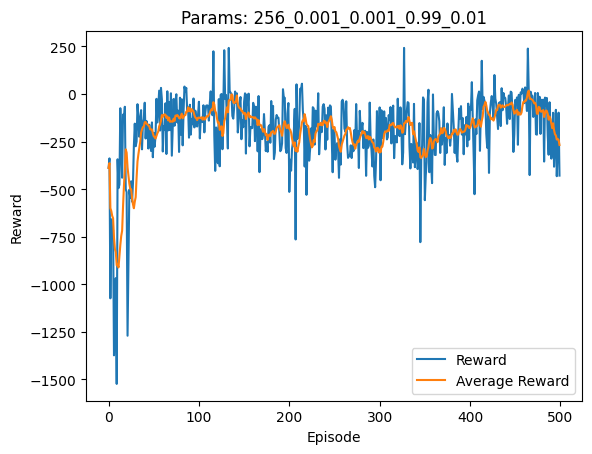

In [10]:
"""
Used for hyperparameter optimization.

"""

n_episodes = 500
n_timesteps = 10000

# Defined parameter-grid
layer_sizes = [256]
actor_lrs = [1e-4,  1e-3]
critic_lrs = [1e-4, 1e-3]
gammas = [0.99]
taus = [0.001, 0.01]
memory = [50000, 100000]

# Create a list of all hyperparameter combinations
hyperparameter_combinations = itertools.product(layer_sizes, actor_lrs, critic_lrs, gammas, taus, memory)

# Initialize lists to store the results of each hyperparameter combination
results = []
best_hyperparameters = None

noise = OUNoise(env.action_space)

# Iterate through all hyperparameter combinations
for hyperparameters in hyperparameter_combinations:
    wandb.init()
    layer_size, actor_lr, critic_lr, gamma, tau, memory = hyperparameters

    # Initialize Gym environment
    env = gym.make("LunarLanderContinuous-v2")

    # Initialize DDPG Agent
    agent = DDPGAgent(env=env,
                      layer_size=layer_size,
                      actor_lr=actor_lr,
                      critic_lr=critic_lr,
                      gamma=gamma,
                      tau=tau,
                      memory_size=memory,
                      batch_size=128)

    rewards = []
    avg_rewards = []
    best_reward = -np.inf

    # Training loop for each hyperparameter combination
    for episode in range(n_episodes):
        state, _ = env.reset()
        noise.reset()
        ep_reward = 0

        for step in range(n_timesteps):
        
            action = agent.act(state)
            action = noise.get_action(action, step)
            next_state, reward, done, _, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)

            state = next_state
            ep_reward += reward
            if done:
                # implemented logging with Weigths & Biases
                wandb.log({'accumulated_reward': ep_reward, 'episode': episode+1, 'name': f'{layer_size}_{actor_lr}_{critic_lr}_{gamma}_{tau}'})
                break

        rewards.append(ep_reward)
        avg_rewards.append(np.mean(rewards[-10:]))

        print("Episode: {}, Reward: {}, Average Reward: {} \n".format(episode + 1,
                                                                    np.round(ep_reward, decimals=2),
                                                                    np.mean(rewards[-10:])))
        
        # save the best model for each hyperparameter combination 
        if ep_reward > best_reward:
            best_reward = ep_reward
            best_agent = agent
            torch.save(agent.actor.state_dict(), f'./models/best_{layer_size}_{actor_lr}_{critic_lr}_{gamma}_{tau}_{memory}.pt')
            torch.save(agent.critic.state_dict(), f'./models/best_{layer_size}_{actor_lr}_{critic_lr}_{gamma}_{tau}_{memory}.pt')
            print(f"Model in Episode {episode + 1} archived new best reward: {np.round(best_reward, decimals=2)}.")

    # Calculate the average reward for the last 10 episodes
    avg_reward = np.mean(rewards[-10:])
    results.append((hyperparameters, avg_reward))

    # Check if the current hyperparameters result in the best average reward
    if avg_reward > best_reward:
        best_reward = avg_reward
        best_hyperparameters = hyperparameters

    print("Hyperparameters:", hyperparameters)
    print("Average Reward:", avg_reward)

    plt.clf()
    plt.title(f'Params: {layer_size}_{actor_lr}_{critic_lr}_{gamma}_{tau}')
    plt.plot(rewards, label='Reward')
    plt.plot(avg_rewards, label='Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.savefig(f'./images/{layer_size}_{actor_lr}_{critic_lr}_{gamma}_{tau}_{memory}.png')


# Print the best hyperparameters and the corresponding best average reward
print("\nBest Hyperparameters:", best_hyperparameters)
print("Best Average Reward:", best_reward)

Basierend auf den durchschnittlichen Reward wurde die folgende Hyperparameterkombination gewählt: 
  - Layer-Size: 256 
  - Actor LR: 0.0001 
  - Critic LR: 0.001 
  - Gamma: 0.99 
  - Tau: 0.001 
  - Memory: 50000
  
Mit dieser konnte ein durchschnittlicher Reward von -88.53 erzielt werden. Da aus dem Trainingsverlauf jedoch hervorgeht, dass \
weiterhin Optimierungspotenzial vorliegt, wurde die Parameterkombination als Grundlage für weitere Trainingsläufe genutzt. 

## Training des finalen Modells

Episode: 1, Reward: -473.02, Average Reward: -473.02000576362366 

Model in Episode 1 archived new best reward: -473.02.
Episode: 2, Reward: -501.39, Average Reward: -487.2067949940894 

Episode: 3, Reward: -210.99, Average Reward: -395.1347233564483 

Model in Episode 3 archived new best reward: -210.99.
Episode: 4, Reward: -74.72, Average Reward: -315.03079961105715 

Model in Episode 4 archived new best reward: -74.72.
Episode: 5, Reward: -611.92, Average Reward: -374.409337067829 

Episode: 6, Reward: -374.64, Average Reward: -374.4483503845226 

Episode: 7, Reward: -277.67, Average Reward: -360.6229552422433 

Episode: 8, Reward: -217.23, Average Reward: -342.69918857609 

Episode: 9, Reward: -368.78, Average Reward: -345.5966973050097 

Episode: 10, Reward: -329.05, Average Reward: -343.9419981981531 

Episode: 11, Reward: -344.78, Average Reward: -331.1179709653395 

Episode: 12, Reward: -533.12, Average Reward: -334.290499137932 

Episode: 13, Reward: -213.48, Average Reward: -

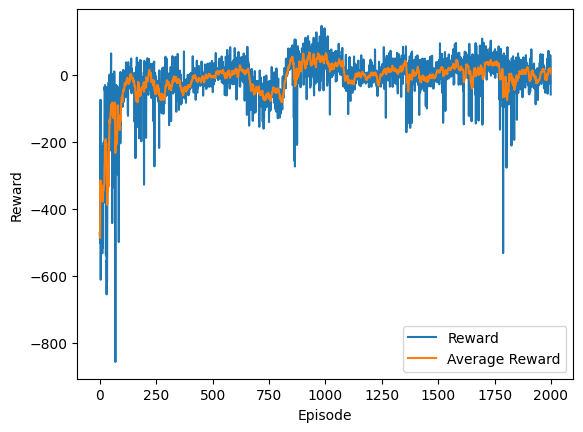

In [12]:
n_episodes = 2000
n_timesteps = 150

# Initialize Gym environment
env = gym.make("LunarLanderContinuous-v2", render_mode="rgb_array")

agent = DDPGAgent(env=env,
                  layer_size=128,
                  actor_lr=0.0001,
                  critic_lr=0.001,
                  gamma=0.90, 
                  tau=0.01,
                  memory_size=50000,
                  batch_size=128)

noise = OUNoise(env.action_space)
rewards, avg_rewards = list(), list()
best_reward = -np.inf

# Initial global step for noise decay
global_step = 0 

# Iterate through a specified number of episodes
for episode in range(n_episodes):
    
    # Reset the state to the initial state
    state, _ = env.reset()
    noise.reset()
    ep_reward = 0

    for step in range(n_timesteps):

        # Choose an action based on the current state
        action = agent.act(state)
        # Add exploration noise to the action
        action = noise.get_action(action, global_step)
        # Execute the action in the environment and obtain the next state and reward
        next_state, reward, done, truncated, _ = env.step(action)
        # Perform a learning step for the agent based on the experienced transition
        agent.step(state, action, reward, next_state, done)

        state = next_state
        ep_reward += reward
        global_step += 1  

        if done or truncated:
            break

    rewards.append(ep_reward)
    # Calculate the moving average of rewards   
    avg_rewards.append(np.mean(rewards[-10:]))

    print("Episode: {}, Reward: {}, Average Reward: {} \n".format(episode + 1,
                                                                  np.round(ep_reward, decimals=2),
                                                                  np.mean(rewards[-10:])))

    if ep_reward > best_reward:
        best_reward = ep_reward
        best_agent = agent
        torch.save(agent.actor.state_dict(), 'best_ddpg_actor_weights.pt')
        torch.save(agent.critic.state_dict(), 'best_ddpg_critic_weights.pt')
        print(f"Model in Episode {episode + 1} archived new best reward: {np.round(best_reward, decimals=2)}.")

# Plot the rewards and average rewards
plt.plot(rewards, label='Reward')
plt.plot(avg_rewards, label='Average Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.savefig(f'./final_model/learning_curve.png')
plt.show()


## Load stored model

In [ ]:
# Load saved weights
actor_weights = torch.load('./final_model/best_ddpg_actor_weights.pt')
critic_weights = torch.load('./final_model/best_ddpg_critic_weights.pt')
final_agent = DDPGAgent(env=env,
                  layer_size=128,
                  actor_lr=0.0001,
                  critic_lr=0.001,
                  gamma=0.90, 
                  tau=0.01,
                  memory_size=50000,
                  batch_size=128)

final_agent.actor.load_state_dict(actor_weights)
final_agent.critic.load_state_dict(critic_weights)

<All keys matched successfully>

## Test the model in jupyter-notebook

Episode 1 terminated with Reward 110.46943123188454


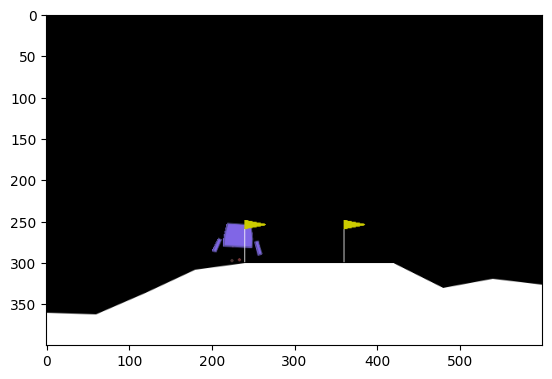

In [19]:
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

seed = 42
np.random.seed(seed)

n_episodes = 1
n_timesteps = 200

env = gym.make('LunarLanderContinuous-v2', render_mode='rgb_array')
env.reset()
img = plt.imshow(env.render()) 

state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

rewards = list()

for episode in range(n_episodes):
    state, _ = env.reset()
    ep_reward = 0

    for step in range(n_timesteps):
        
        img.set_data(env.render()) 
        display.display(plt.gcf())
        display.clear_output(wait=True)

        action = final_agent.actor(torch.from_numpy(state)).cpu().detach().numpy()
        next_state, reward, done, truncated, _ = env.step(action)

        state = next_state
        ep_reward += reward

        if done or truncated:
            break

    rewards.append(ep_reward)
    print(f'Episode {episode+1} terminated with Reward {ep_reward}')

## Test the model in pygame

In [23]:
np.random.seed(seed)

n_episodes = 10
n_timesteps = 250
fps = 30 

# Initialize Gym environment
env = gym.make('LunarLanderContinuous-v2', render_mode='human')

# Set up Pygame display
pygame.init()
display_width, display_height = 800, 600
screen = pygame.display.set_mode((display_width, display_height))
pygame.display.set_caption('Lunar Lander')

state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

rewards = list()

# Function to display text on the Pygame screen
def display_text(text, x, y, size=25, color=(255, 255, 255)):
    font = pygame.font.Font(None, size)
    text_surface = font.render(text, True, color)
    screen.blit(text_surface, (x, y))

# Create a Pygame clock object to control the frame rate
clock = pygame.time.Clock()

for episode in range(n_episodes):
    state, _ = env.reset()
    ep_reward = 0

    for step in range(n_timesteps):
        for event in pygame.event.get():
            if event.type == QUIT:
                pygame.quit()
                quit()

        action = final_agent.actor(torch.from_numpy(state)).cpu().detach().numpy()
        next_state, reward, done, truncated, _ = env.step(action)

        state = next_state
        ep_reward += reward

        # Render the environment in Pygame
        env.render()

        # Display reward on the Pygame screen
        display_text(f'Reward: {ep_reward:.2f}', 10, 10)

        pygame.display.update()
        clock.tick(fps)

        if done or truncated:
            break

    rewards.append(ep_reward)
    print(f'Episode {episode + 1} terminated with Reward {ep_reward:.2f}')

# Close Pygame display
pygame.quit()


Episode 1 terminated with Reward 41.36
Episode 2 terminated with Reward 82.59
Episode 3 terminated with Reward -21.28
Episode 4 terminated with Reward -41.79
Episode 5 terminated with Reward 143.54
Episode 6 terminated with Reward 97.70
Episode 7 terminated with Reward 84.72
Episode 8 terminated with Reward 129.09
Episode 9 terminated with Reward 83.07
Episode 10 terminated with Reward 149.49
